In [1]:
# To run this in Google Colab, uncomment the following line
# !pip install "git+https://github.com/GPflow/GeometricKernels.git"

# If you want to use a version of the library from a different git branch,
# say, from the "devel" branch, uncomment the line below instedad
# !pip install "git+https://github.com/GPflow/GeometricKernels@devel#egg=GeometricKernels"

# Matérn and Heat Kernels on Meshes
This notebook shows how define and evaluate kernels on a simple mesh.

Inside, we use [potpourri3d](https://github.com/nmwsharp/potpourri3d) and [robust_laplacian](https://github.com/nmwsharp/robust-laplacians-py) to work with meshes.

We use the **numpy** backend here.

In [2]:
# Import a backend, we use numpy in this example.
import numpy as np
# Import the geometric_kernels backend.
import geometric_kernels
# Import a space and an appropriate kernel.
from geometric_kernels.spaces import Mesh
from geometric_kernels.kernels import MaternKarhunenLoeveKernel

import matplotlib as mpl
import matplotlib.pyplot as plt

from pathlib import Path
import plotly.graph_objects as go
from plotly.subplots import make_subplots

INFO: Using numpy backend


## Defining a Space

First, we create a GeometricKernels space that correponds to a teddy bear mesh loaded from "../data/teddy.obj"

In [3]:
mesh = Mesh.load_mesh(str(Path.cwd().parent / "data" / "teddy.obj"))
print("Number of vertices in the mesh:", mesh.num_vertices)

Number of vertices in the mesh: 1598


We define mesh plotting utils for `plotly`

In [4]:
def update_figure(fig):
    """Utility to clean up figure"""
    fig.update_layout(scene_aspectmode="cube")
    fig.update_scenes(xaxis_visible=False, yaxis_visible=False, zaxis_visible=False)
    # fig.update_traces(showscale=False, hoverinfo="none")
    fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))

    fig.update_layout(plot_bgcolor="rgba(0,0,0,0)", paper_bgcolor="rgba(0,0,0,0)")
    fig.update_layout(
        scene=dict(
            xaxis=dict(showbackground=False, showticklabels=False, visible=False),
            yaxis=dict(showbackground=False, showticklabels=False, visible=False),
            zaxis=dict(showbackground=False, showticklabels=False, visible=False),
        )
    )
    return fig

def plot_mesh(mesh: Mesh, vertices_colors = None, **kwargs):
    plot = go.Mesh3d(
        x=mesh.vertices[:, 0],
        y=mesh.vertices[:, 1],
        z=mesh.vertices[:, 2],
        i=mesh.faces[:, 0],
        j=mesh.faces[:, 1],
        k=mesh.faces[:, 2],
        colorscale='viridis',
        intensity=vertices_colors,
        **kwargs
    )
    return plot

Now we actually visualize the mesh.

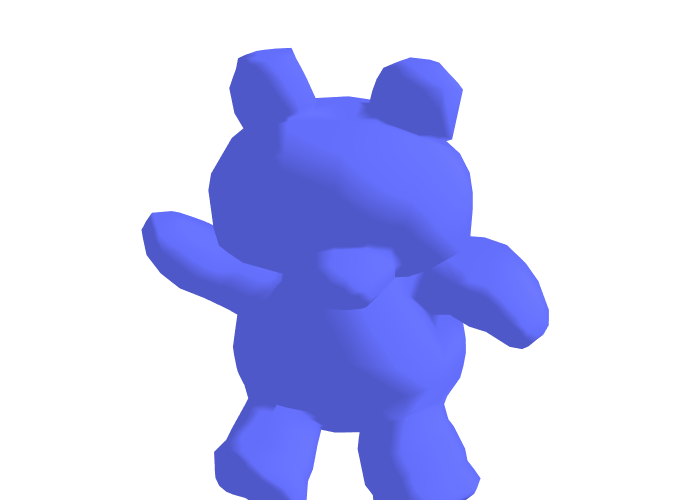

In [5]:
# Define the camera
camera = dict(
    up=dict(x=0, y=1, z=0),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=0, y=0.7, z=1.25)
)

plot = plot_mesh(mesh)
fig = go.Figure(plot)
update_figure(fig)
fig.update_layout(
    scene_camera=camera
)
fig.show('png')

## Theory (Optional Reading)
### General Theory Behind `MaternKarhunenLoeveKernel` for Meshes

Consider a mesh $M$ with $N$ nodes.
There are a few notions of *Laplacian* $\mathbf{\Delta}$ for $M$, which is always a positive semidefinite matrix of size $N \times N$. We use the *robust Laplacian* by Sharp and Crane (2020) implemented in the [robust_laplacian](https://github.com/nmwsharp/robust-laplacians-py) package.

Since $\mathbf{\Delta}$ is positive semidefinite, there is an orthonormal basis $\{\boldsymbol f_n\}_{n=1}^N$ in $\mathbb{R}^N$ of eigenvectors such that $\mathbf{\Delta} \boldsymbol f_n = \lambda_n \boldsymbol f_n$ for $0 = \lambda_1 \leq \lambda_2 \leq \ldots \leq \lambda_N$.

The eigenvectors $f_n$ can be regarded as functions on the mesh nodes: $f_n(j) = (f_n)_j$.
In these terms, the `MaternKarhunenLoeveKernel` on $M$ is then given by the formula
$$
k_{\nu, \kappa}(i,j)
=
\frac{1}{C_{\nu, \kappa}} \sum_{n=1}^L \Phi_{\nu, \kappa}(\lambda_n) f_n(i) f_n(j)
\qquad
\qquad
\Phi_{\nu, \kappa}(\lambda)
=
\begin{cases}
\left(\frac{2\nu}{\kappa^2} + \lambda\right)^{-\nu - d/2}
&
\nu < \infty \text{ — Matérn}
\\
e^{-\frac{\kappa^2}{2} \lambda}
&
\nu = \infty \text{ — Heat (RBF)}
\end{cases}
$$
The notation is as follows.
* $d$ is the dimension of the mesh (i.e. the dimension of the implied manifold the mesh approximates). In our implementation $d = 2$ as we only handle 2-dimensional meshes in $\mathbb{R}^3$.

* $1 \leq L \leq N$ controls the quality of approximation of the kernel.
Setting $L = N$ gives you the exact kernel but usually requires $O(N^3)$ to compute the eigenpairs.
Setting $L \ll N$ can in principle allow much faster eigenpair computation for some graphs, such techniques are, however, not (yet) implemented in GeometricKernels.

* The constant $C_{\nu, \kappa}$ above ensures that average variance is equal to $1$, i.e. $\frac{1}{N} \sum_{n=1}^N k(n, n) = 1$.
It is easy to show that $C_{\nu, \kappa} = \sum_{n=1}^L \Phi_{\nu, \kappa}(\lambda_n)$.

**Note:** the "variance" $k(x, x)$ can vary from point to point.

## Defining a Kernel

First, we create a generic Matérn kernel.

To initialize `MaternKarhunenLoeveKernel`, you provide two parameters.
First, the `space`, in our case this is the `mesh` we have just created above.
The second parameter, `num_eigenfunctions`, determines the number of terms in the approximation of the kernel.
We recommend to set `num_eigenfunctions` to a few hundreds.
Depending on your specific problem you may want to change it.

**Note:** the `num_eigenfunctions` parameter is equal to $L$ in terms of the theory above, it corresponds to the number of eigenpairs of the Laplacian used to approximate the kernel.

In [6]:
kernel = MaternKarhunenLoeveKernel(mesh, 500)

To support JAX, our classes do not contain a *state*, it is external.
The next line initializes the *state* which is composed of two parts: `params`, a dictionary with kernel parameters, and `state`, a dictionary containing the eigenpairs.

`params` are initialized with some default values.

**Note:** our kernels do not contain the outputscale/variance parameter frequently used in Gaussian processes.
However, it is usually trivial to add it by multiplying the kernel by an (optimizable) constant.

In [7]:
params, state = kernel.init_params_and_state()
print('params:', params)
print('state:', state)

params: {'lengthscale': array(1.), 'nu': array(inf)}
state: {'eigenvalues_laplacian': array([[3.44714616e-18],
       [3.19591842e-03],
       [7.69276157e-03],
       [9.90261631e-03],
       [1.32890363e-02],
       [1.55137248e-02],
       [1.93017472e-02],
       [2.33486800e-02],
       [2.76577389e-02],
       [3.34102570e-02],
       [3.58550117e-02],
       [3.88616355e-02],
       [3.95432120e-02],
       [4.77057727e-02],
       [5.65742402e-02],
       [6.12408464e-02],
       [6.39681130e-02],
       [6.53869847e-02],
       [7.06840320e-02],
       [7.48813465e-02],
       [7.70570149e-02],
       [7.87193297e-02],
       [8.45518973e-02],
       [8.93700979e-02],
       [9.18066848e-02],
       [9.41357629e-02],
       [9.70986224e-02],
       [9.76446309e-02],
       [1.03765628e-01],
       [1.08187592e-01],
       [1.09464360e-01],
       [1.14797071e-01],
       [1.18825712e-01],
       [1.22841215e-01],
       [1.26519948e-01],
       [1.33117116e-01],
       [1.3525

To define two different kernels, Matern-3/2 and Matern-∞ (aka heat, RBF, squared exponential, diffusion), we need two different versions of `params`:

In [8]:
params["lengthscale"] = np.array([2.0])
params_32  = params.copy()
params_inf = params.copy()
del params
params_32["nu"]  = np.array([3/2])
params_inf["nu"] = np.array([np.inf])

Now two kernels are *defined* and we proceed to evaluating both on a set of random inputs.

## Evaluating Kernels on Random Inputs

We start by sampling `10` (uniformly) random points on our mesh.
An explicit `key` parameter is needed to support JAX as one of the backends.

In [9]:
key = np.random.RandomState(1234)

key, xs = mesh.random(key, 10)

print(xs)

[[ 815]
 [ 723]
 [1318]
 [1077]
 [1228]
 [1396]
 [ 664]
 [ 689]
 [ 279]
 [1257]]


Now we evaluate the two kernel matrices.

In [10]:
kernel_mat_32  = kernel.K(params_32,  state, xs, xs)
kernel_mat_inf = kernel.K(params_inf, state, xs, xs)

Finally, we visualize these matrices using `imshow`.

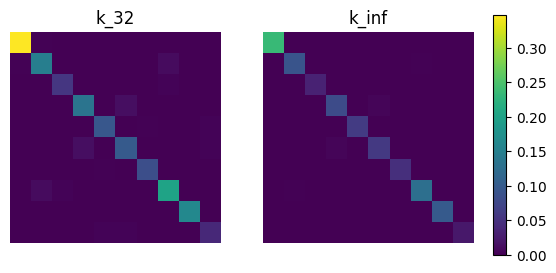

In [11]:
# find common range of values
minmin = np.min([np.min(kernel_mat_32), np.min(kernel_mat_inf)])
maxmax = np.max([np.max(kernel_mat_32), np.max(kernel_mat_inf)])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
cmap = plt.get_cmap('viridis')

ax1.imshow(kernel_mat_32, vmin=minmin, vmax=maxmax, cmap=cmap)
ax1.set_title('k_32')
ax1.set_axis_off()

ax2.imshow(kernel_mat_inf, vmin=minmin, vmax=maxmax, cmap=cmap)
ax2.set_title('k_inf')
ax2.set_axis_off()

# add space for color bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])

# add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=minmin, vmax=maxmax))
fig.colorbar(sm, cax=cbar_ax)

plt.show()

## Visualize Kernels

Here we visualize $k_{\nu, \kappa}($ `base_point` $, x)$ for $x \in $ `other_points`.
We define `base_point` and `other_points` in the next cell.

In [12]:
base_point = 1 # choosing a fixed node for kernel visualization
other_points = np.arange(mesh.num_vertices)[:, None]

The next cell evaluates $k_{\nu, \kappa}($ `base_point` $, x)$ for $x \in $ `other_points` for $\nu$ either $3/2$ or $\infty$.

In [13]:
values_32  = np.asarray(kernel.K(params_32,  state, np.array([[base_point]]),
                              other_points)).flatten()
values_inf = np.asarray(kernel.K(params_inf, state, np.array([[base_point]]),
                              other_points)).flatten()

We also evaluate the variances $k_{\nu, \kappa}(x, x)$ for $x \in $ `other_points` for $\nu$ either $3/2$ or $\infty$.

In [14]:
# Get prior variances k(*, *) for * in nodes:
variance_32  = np.asarray(kernel.K_diag(params_32,  state, other_points))
variance_inf = np.asarray(kernel.K_diag(params_inf, state, other_points))

Here are the actual visualization routines.

**Note:** the top right plot shows `k(base_point, *)` where `*` goes through all nodes and `base_point` has red outline. 

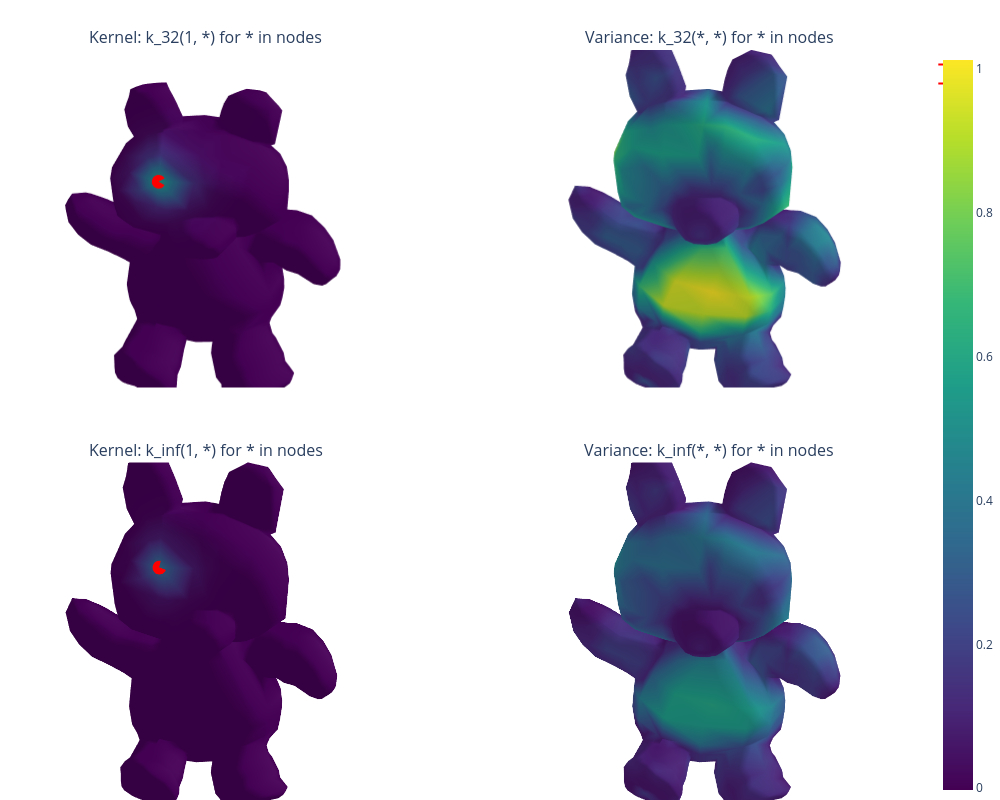

In [15]:
# Set the colorbar limits:
vmin = min(0.0, values_32.min(), values_inf.min())
vmax = max(1.0, variance_32.max(), variance_inf.max())
contours=dict(start=vmin, end=vmax)


# Marker for the base_point
base_point_plot  = go.Scatter3d(
    x=np.array([mesh.vertices[base_point][0]]),
    y=np.array([mesh.vertices[base_point][1]]),
    z=np.array([mesh.vertices[base_point][2]]),
    marker_color = 'red',
    name=''
)

# Various plots as plotly traces
values_32_plot     = plot_mesh(mesh, vertices_colors=values_32,    coloraxis = "coloraxis")
values_inf_plot    = plot_mesh(mesh, vertices_colors=values_inf,   coloraxis = "coloraxis")
variance_32_plot   = plot_mesh(mesh, vertices_colors=variance_32,  coloraxis = "coloraxis")
variance_inf_plot  = plot_mesh(mesh, vertices_colors=variance_inf, coloraxis = "coloraxis")

# Setting up the layout
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{'type': 'surface'}, {'type': 'surface'}],
           [{'type': 'surface'}, {'type': 'surface'}]],
    subplot_titles=("Kernel: k_32(1, *) for * in nodes",
                    "Variance: k_32(*, *) for * in nodes",
                    "Kernel: k_inf(1, *) for * in nodes",
                    "Variance: k_inf(*, *) for * in nodes"),
    vertical_spacing=0.1)

# Adding the traces
fig.add_trace(base_point_plot,    row=1, col=1)
fig.add_trace(values_32_plot,     row=1, col=1)

fig.add_trace(base_point_plot,    row=2, col=1)
fig.add_trace(values_inf_plot,    row=2, col=1)

fig.add_trace(variance_32_plot,   row=1, col=2)

fig.add_trace(variance_inf_plot,  row=2, col=2)

fig = update_figure(fig)

fig.layout.scene1.camera = camera
fig.layout.scene2.camera = camera
fig.layout.scene3.camera = camera
fig.layout.scene4.camera = camera


fig.update_layout(
    margin={'t': 50},
    coloraxis = {'colorscale':'viridis'},
)

fig.show('png', width=1000, height=800)

# Citations

If you are using meshes and GeometricKernels, please consider citing

```
@article{borovitskiy2020,
    title={Matern Gaussian processes on Riemannian manifolds},
    author={Viacheslav Borovitskiy and Alexander Terenin and Peter Mostowsky and Marc Peter Deisenroth},
    booktitle={Advances in Neural Information Processing Systems},
    year={2020}}
```

```
@article{sharp2020,
  author={Nicholas Sharp and Keenan Crane},
  title={A Laplacian for Nonmanifold Triangle Meshes},
  journal={Computer Graphics Forum (SGP)},
  volume={39},
  number={5},
  year={2020}}
```